In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import and check vgg16, mobilenet, etc.

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
# Variables.
# VGG19 has a required input image dimension of [224, 224].
 
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 20
CHANNELS = 3
EPOCHS = 20
n_classes = 2
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\DataTrained\Practice Data SampleS\CNN\Malaria',
    shuffle = True, 
    image_size = (IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6001 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Parasite', 'Uninfected']

In [5]:
# Creating the training, validation and test splits from the dataset.

def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [7]:
len(train_ds), len(val_ds), len(test_ds)

(240, 30, 31)

In [8]:
# Caching.

# This will read image from disk and store it for next iteration and improves perfomance.
# prefetch() will load the next batch size just incase the GPU is busy training.


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
# Resizing the images.

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
# Data Augmentation.

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [11]:
# Importing VGG19 library and adding the preprocessing layers to the front.
# We will be using imagenet weights.
# '+ [3]' is for the RGB channel.

vgg19arc = VGG19(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

In [12]:
# VGG19 Architecture.

vgg19arc.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# Since we're using transfer learning, we will not be training every layers. 
# We're just going to use the weights in those layers, there won't be any re-training. 
# Re-training should only happen in the last layer, for rest, we use the model.

for layers in vgg19arc.layers:
    layers.trainable = False

In [14]:
# Added data augmentation, resizing and rescaling layers before the VGG19 model.
# Added the flattening and dense layers after the VGG19 model.

input = Input(shape=(224, 224, 3))
x = data_augmentation(input)
x = resize_and_rescale(x)
x = vgg19arc(x)
x = Flatten()(x)
output = Dense(len(class_names), activation = 'softmax')(x)
#output = prediction(x)
model = Model(inputs = input, outputs = output)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 50178     
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
____________________________________________

In [16]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [17]:
# Fitting and running the model.

runtime = model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE, 
    verbose = 1,
    steps_per_epoch = len(train_ds),
    validation_steps = len(val_ds)
)

Epoch 1/20
240/240 [==============================] - 129s 399ms/step - loss: 0.5508 - accuracy: 0.7515 - val_loss: 0.3789 - val_accuracy: 0.8267
Epoch 2/20
240/240 [==============================] - 73s 296ms/step - loss: 0.3852 - accuracy: 0.8327 - val_loss: 0.3503 - val_accuracy: 0.8383
Epoch 3/20
240/240 [==============================] - 66s 274ms/step - loss: 0.4534 - accuracy: 0.8269 - val_loss: 0.3170 - val_accuracy: 0.8750
Epoch 4/20
240/240 [==============================] - 66s 274ms/step - loss: 0.3689 - accuracy: 0.8573 - val_loss: 0.3701 - val_accuracy: 0.8767
Epoch 5/20
240/240 [==============================] - 66s 274ms/step - loss: 0.3487 - accuracy: 0.8673 - val_loss: 0.2887 - val_accuracy: 0.8900
Epoch 6/20
240/240 [==============================] - 66s 275ms/step - loss: 0.3493 - accuracy: 0.8640 - val_loss: 0.2772 - val_accuracy: 0.8883
Epoch 7/20
240/240 [==============================] - 66s 276ms/step - loss: 0.3633 - accuracy: 0.8658 - val_loss: 0.4062 - val_a

In [18]:
scores = model.evaluate(test_ds)

31/31 [==============================] - 29s 248ms/step - loss: 0.2863 - accuracy: 0.8887


In [19]:
scores

[0.286285936832428, 0.8887096643447876]

In [20]:
runtime.history['accuracy']

[0.7514583468437195,
 0.8327083587646484,
 0.8268749713897705,
 0.8572916388511658,
 0.8672916889190674,
 0.8639583587646484,
 0.8658333420753479,
 0.8722916841506958,
 0.871874988079071,
 0.8847916722297668,
 0.8837500214576721,
 0.87520831823349,
 0.8833333253860474,
 0.8793749809265137,
 0.887499988079071,
 0.8854166865348816,
 0.8843749761581421,
 0.8806250095367432,
 0.8958333134651184,
 0.8868749737739563]

In [21]:
acc = runtime.history['accuracy']
val_acc = runtime.history['val_accuracy']

loss = runtime.history['loss']
val_loss = runtime.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

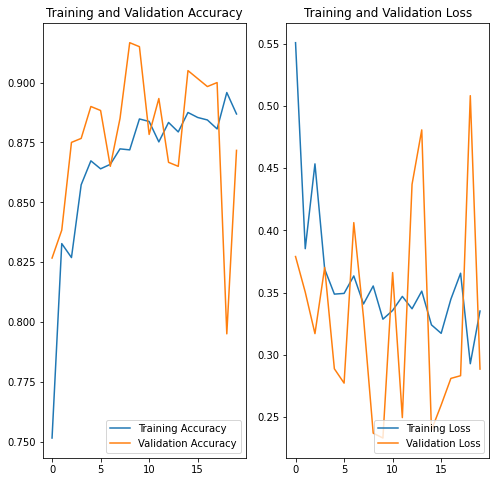

In [22]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

Parasite


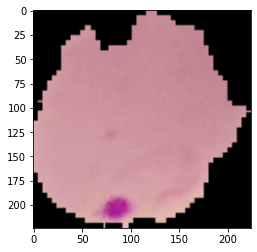

In [23]:
for images_batch, labels_batch in test_ds.take(1):
    
    plt.imshow(images_batch[0].numpy().astype('uint8'))
    
    prediction = model.predict(images_batch)
    print(class_names[np.argmax(prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    prediction = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])), 2)
    return predicted_class, confidence

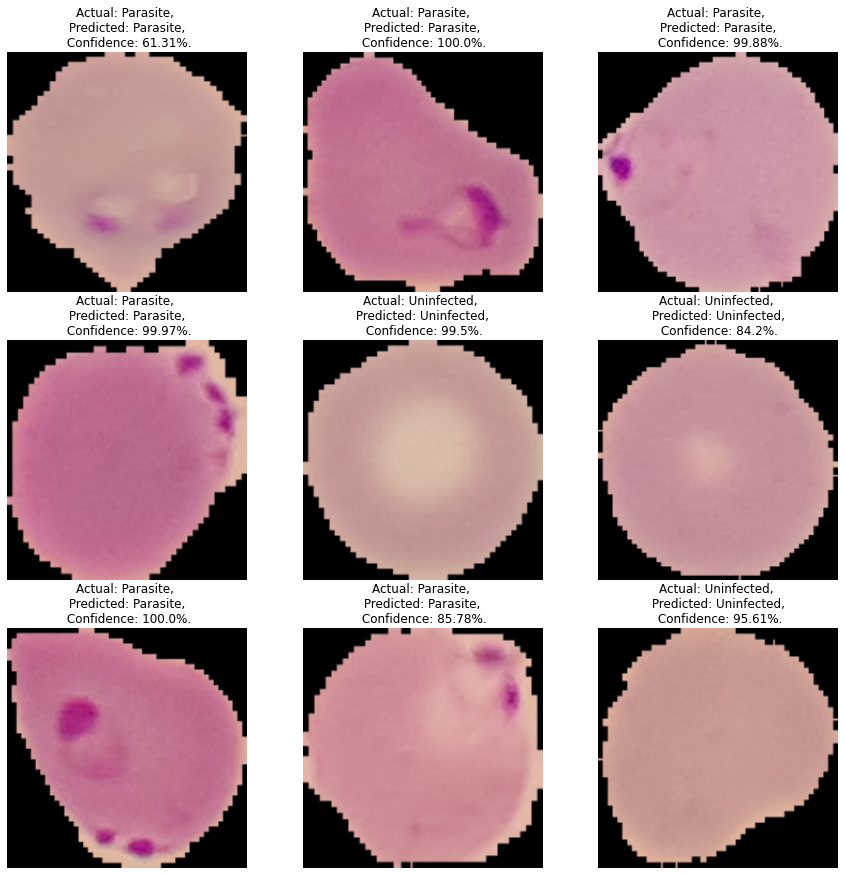

In [25]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%.')

In [26]:
model.save(f'../Models/MalariaDetection_CNN_VGG19_TL.h5')